# NSF Computer and Information Science and Engineering (CISE) 

- `0505****`: Division of Computer and Network Systems (CNS)
- `0501****`: Division of Computing and Communication Foundations (CCF)
- `0502****`: Division of Information and Intelligent Systems (IIS)
- `0509****`: Office of Advanced Cyberinfrastructure (OAC)

In [3]:
import os,sys,json
import core.coworknet, core.nsf_utils
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd
from datetime import datetime
from collections import Counter

In [4]:
grant_type = ["Standard Grant", "Continuing grant"] # draw only these types
div_type = {
    "0505": "Division of Computer and Network Systems (CNS)",
    "0501": "Division of Computing and Communication Foundations (CCF)",
    "0502": "Division of Information and Intelligent Systems (IIS)",
    "0509": "Office of Advanced Cyberinfrastructure (OAC)"
}

In [5]:
data = {}
years = [2004]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"][:4] == code and v["year"] == y]))

[2004]
Total number of grants 10212
Division of Computer and Network Systems (CNS) 413
Division of Computing and Communication Foundations (CCF) 349
Division of Information and Intelligent Systems (IIS) 365
Office of Advanced Cyberinfrastructure (OAC) 53


In [7]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(grant_list)

['0401049', '0403020', '0403130', '0403590', '0404001', '0404011', '0404193', '0404297', '0404440', '0406305', '0406345', '0406384', '0410203', '0410246', '0410409', '0410524', '0410553', '0410771', '0410790', '0410918', '0410937', '0411127', '0411152', '0411307', '0412029', '0412858', '0412884', '0412894', '0412930', '0412965', '0413012', '0413078', '0413085', '0413138', '0413196', '0413214', '0413227', '0413251', '0413284', '0413321', '0413328', '0413709', '0414380', '0414409', '0414482', '0414557', '0414567', '0414630', '0414710', '0414762', '0414763', '0414791', '0414815', '0414976', '0414981', '0415016', '0415021', '0415101', '0415175', '0415195', '0415257', '0415865', '0415923', '0416364', '0417607', '0418165', '0420337', '0420434', '0420505', '0420866', '0420873', '0420906', '0420985', '0423014', '0423039', '0423070', '0423253', '0423305', '0423546', '0423584', '0424601', '0426021', '0426557', '0426627', '0426674', '0426879', '0426904', '0427260', '0427385', '0427695', '0428427'

In [8]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

246 grants with 2 PIs


In [9]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
for pid in grant_list:
    award, table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
    if len(table) == 0:
        no_publications.append(pid)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(pis)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
#     print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) == 2 and pi_max_group == 2:
        two_cowork.append(pid)
    elif len(pi_union) == 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

97 (39.43%) grants have no publication
42 (17.07%) grants have only one working PI
15 (6.10%) grants have two PIs working separately
85 (34.55%) grants have two PIs collaborated
7 (2.85%) grants are unknown


In [54]:
dict_grant = dict()
for grant_id in only_one_pi:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pinfo = {}
    for inv in award["investigators"]:
        if inv["candidates"]:
            for inv_c in inv["candidates"]:
                pinfo[inv_c[0]] = inv["role"]
        else:
            pinfo[inv["authorId"]] = inv["role"]
#     print("***", pinfo)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a]["pi"]]
#     print("PIs", G_all.nodes.data())
#     print(grant_id)
    working_pi = None
    for u,v,data in G_all.edges.data():
        if u in pis:
            working_pi = u

    non_working_pi = pis[1] if working_pi == pis[0] else pis[0]
   
    d_working_pi = G_all.nodes()[working_pi]
    d_working_pi["role"] = pinfo[d_working_pi["id"]]
    d_non_working_pi = G_all.nodes()[non_working_pi]
    d_non_working_pi["role"] = pinfo[d_non_working_pi["id"]]
    
    print(d_working_pi, d_non_working_pi)
    dict_grant[grant_id] = {
        "working_pi": d_working_pi,
        "non_working_pi": d_non_working_pi
    }

{'norm': 'olivia r liu sheng', 'id': 2285781625, 'paperCount': 107, 'citationCount': 3013, 'pi': True, 'role': 'Principal Investigator'} {'norm': 'hu paul', 'id': 2499690653, 'paperCount': 1, 'citationCount': 52, 'pi': True, 'role': 'Co-Principal Investigator'}
{'norm': 'keith w ross', 'id': 2297273366, 'paperCount': 130, 'citationCount': 6259, 'pi': True, 'role': 'Co-Principal Investigator'} {'norm': 'phyllis g frankl', 'id': 2044835467, 'paperCount': 55, 'citationCount': 2751, 'pi': True, 'role': 'Principal Investigator'}
{'norm': 'jeanclaude latombe', 'id': 1545294347, 'paperCount': 234, 'citationCount': 20636, 'pi': True, 'role': 'Co-Principal Investigator'} {'norm': 'stephen m rock', 'id': 2096219353, 'paperCount': 164, 'citationCount': 3632, 'pi': True, 'role': 'Principal Investigator'}
{'norm': 'thorsten joachims', 'id': 245171893, 'paperCount': 193, 'citationCount': 37121, 'pi': True, 'role': 'Principal Investigator'} {'norm': 'rich caruana', 'id': 2106722673, 'paperCount': 111

In [55]:
Counter([p["working_pi"]["role"] for p in dict_grant.values()])

Counter({'Principal Investigator': 30,
         'Co-Principal Investigator': 9,
         'Former Principal Investigator': 3})

In [56]:
Counter([p["non_working_pi"]["role"] for p in dict_grant.values()])

Counter({'Co-Principal Investigator': 26,
         'Principal Investigator': 12,
         'Former Co-Principal Investigator': 2,
         'Former Principal Investigator': 2})

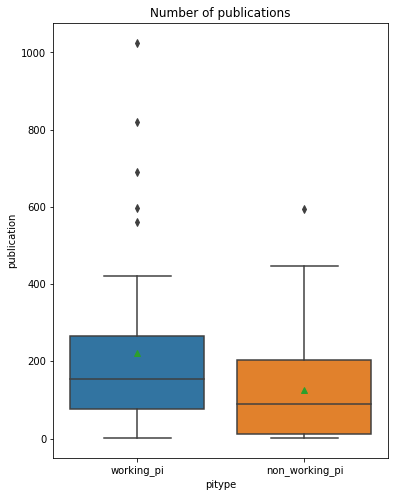

In [24]:
pi_type = ["working_pi", "non_working_pi"]
box_plot_data = pd.DataFrame({
    "publication": [gv[pt]["paperCount"] for pt in pi_type for gid, gv in dict_grant.items()],
    "citation": [gv[pt]["citationCount"] for pt in pi_type for gid, gv in dict_grant.items()],
    "pitype": [pt for pt in pi_type for gid, gv in dict_grant.items()]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="pitype", y="publication", data=box_plot_data, showmeans=True).set_title("Number of publications")


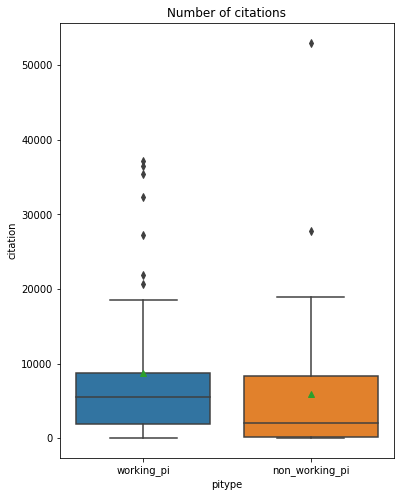

In [25]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="pitype", y="citation", data=box_plot_data, showmeans=True).set_title("Number of citations")

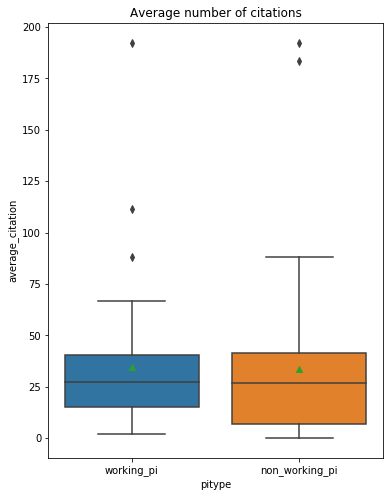

In [27]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="pitype", y="average_citation", data=box_plot_data, showmeans=True).set_title("Average number of citations")


In [57]:
data = {}
years = [2009]
for y in years:
    data.update(core.nsf_utils.load_numpub_data(y))
data = {k:v for k, v in data.items() if v["type"] in grant_type}
for y in years:
    print("[{}]".format(y))
    print("Total number of grants", len([v for v in data.values() if v["year"] == y]))
    for code, desc in div_type.items():
        print(desc, len([v for v in data.values() if v["org"][:4] == code and v["year"] == y]))

[2009]
Total number of grants 14758
Division of Computer and Network Systems (CNS) 733
Division of Computing and Communication Foundations (CCF) 535
Division of Information and Intelligent Systems (IIS) 627
Office of Advanced Cyberinfrastructure (OAC) 193


In [58]:
grant_list = [k for k, d in data.items() if d["org"][:4] in div_type.keys() and d["num_pis"] == 2]
print(len(grant_list), "grants with 2 PIs")

457 grants with 2 PIs


In [59]:
no_publications = []
no_edges = []
other = []
only_one_pi = []
two_separate = []
two_cowork = []
for pid in grant_list:
    award, table, ts, te, G_all = core.coworknet.get_grant_coworknet_pis(pid)
    if len(table) == 0:
        no_publications.append(pid)
        continue
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a] ["pi"]]
    G = G_all.subgraph(pis)
        
    working_pis = []
    reported_pub_number = 0
    for k, v in table.items():
        if v["type"]: # only count publicatoins in-grant
            reported_pub_number += 1
            working_pis.append([a for a, av in v["authors"].items() if av["pi"]])
    # print(pid, working_pis)
    pi_counter = [set([n[0]+n.split(" ")[-1] for n in group]) for group in working_pis]
    pi_union = set.union(*pi_counter)
    pi_max_group = max([len(pg) for pg in pi_counter])
#     print(pi_counter, pi_union, pi_max_group)
#     print("{} union={}, max_group={}, numpub={} {} {}".format(pid, len(pi_union), pi_max_group, reported_pub_number, len(table), len(G.edges)))
    if len(pi_union) == 2 and pi_max_group == 2:
        two_cowork.append(pid)
    elif len(pi_union) == 2:
        two_separate.append(pid)
    elif len(pi_union) == 1:
        only_one_pi.append(pid)
    else:
        other.append(pid)
print("{} ({:.2f}%) grants have no publication".format(len(no_publications), 100*len(no_publications)/len(grant_list)))
print("{} ({:.2f}%) grants have only one working PI".format(len(only_one_pi), 100*len(only_one_pi)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs working separately".format(len(two_separate), 100*len(two_separate)/len(grant_list)))
print("{} ({:.2f}%) grants have two PIs collaborated".format(len(two_cowork), 100*len(two_cowork)/len(grant_list)))
print("{} ({:.2f}%) grants are unknown".format(len(other), 100*len(other)/len(grant_list)))

115 (25.16%) grants have no publication
102 (22.32%) grants have only one working PI
40 (8.75%) grants have two PIs working separately
183 (40.04%) grants have two PIs collaborated
17 (3.72%) grants are unknown


In [71]:
dict_grant = dict()
for grant_id in only_one_pi:
    award,_,ts,te,G_all = core.coworknet.get_grant_coworknet_pis(grant_id)
    pinfo = {}
    for inv in award["investigators"]:
        if inv["candidates"]:
            for inv_c in inv["candidates"]:
                pinfo[inv_c[0]] = inv["role"]
        else:
            pinfo[inv["authorId"]] = inv["role"]
#     print("***", pinfo)
    pis = [a for a in G_all.nodes() if "pi" in G_all.nodes[a] and G_all.nodes[a]["pi"]]
#     print(grant_id, "PIs", pis)
#     print(grant_id)
    working_pi = None
    for u,v,data in G_all.edges.data():
        if u in pis:
            working_pi = u

    try:
        non_working_pi = pis[1] if working_pi == pis[0] else pis[0]
        print(working_pi, ", ", non_working_pi)
        d_working_pi = G_all.nodes()[working_pi]
        d_working_pi["role"] = pinfo[d_working_pi["id"]]
        d_non_working_pi = G_all.nodes()[non_working_pi]
        d_non_working_pi["role"] = pinfo[d_non_working_pi["id"]]

    #     print(d_working_pi, d_non_working_pi)
        dict_grant[grant_id] = {
            "working_pi": d_working_pi,
            "non_working_pi": d_non_working_pi
        }
        
    except Exception as e:
        print("Error:", grant_id, e)
        print("pinfo:", pinfo)
        print("pis:", pis)

Sheldon X.-D. Tan ,  Yingbo Hua
Chris Hill ,  Patrick Heimbach
P. Sadayappan ,  Sriram Krishnamoorthy
Pieter Abbeel ,  Stuart Russell
Kevin Knight ,  Regina Barzilay
Roger Ghanem ,  Dongxiao Zhang
Jack J. Dongarra ,  Sadaf R. Alam
Anshu Dubey ,  Dong-Wook Lee
Holly Y. Yanco ,  Holly A. Yanco
Martin C. Rinard ,  Vijay Ganesh
Xiaohua Tony Hu ,  Aleister J. Saunders
Xindong Wu ,  Marc S. Greenblatt
Yuan Xie ,  Raj S. Acharya
Jian Zhang ,  Rajgopal Kannan
None ,  Lori A. Clarke
Error: 0905530 None
pinfo: {2106467035: 'Co-Principal Investigator', 2248607981: 'Principal Investigator'}
pis: ['Lori A. Clarke', 'Leon J. Osterweil']
Norman M. Sadeh ,  Michael Drielsma
José Meseguer ,  King Samuel
Ramesh Govindan ,  Sun Young Cho
Santosh Kumar ,  J. Gayle Beck
Shirley Moore ,  Daniel Terpstra
Martha Palmer ,  James Martin
Angelos D. Keromytis ,  Michalis Polychronakis
Deniz Erdogmus ,  Rupal Patel
Jason Nieh ,  Angelos D. Keromytis
Nicholas A. Kraft ,  Jeffrey C. Carver
Marcelo Kallmann ,  Teenie

In [72]:
Counter([p["working_pi"]["role"] for p in dict_grant.values()])

Counter({'Principal Investigator': 71,
         'Co-Principal Investigator': 16,
         'Former Principal Investigator': 9})

In [73]:
Counter([p["non_working_pi"]["role"] for p in dict_grant.values()])

Counter({'Co-Principal Investigator': 62,
         'Principal Investigator': 27,
         'Former Principal Investigator': 4,
         'Former Co-Principal Investigator': 3})

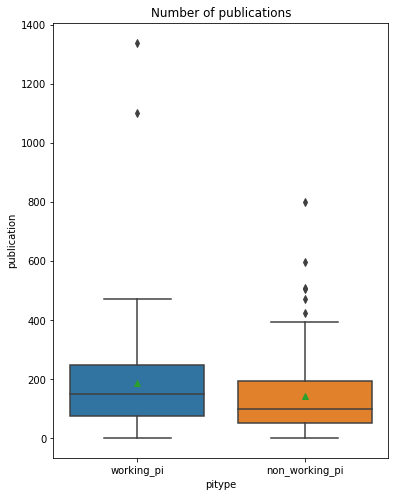

In [74]:
pi_type = ["working_pi", "non_working_pi"]
box_plot_data = pd.DataFrame({
    "publication": [gv[pt]["paperCount"] for pt in pi_type for gid, gv in dict_grant.items()],
    "citation": [gv[pt]["citationCount"] for pt in pi_type for gid, gv in dict_grant.items()],
    "pitype": [pt for pt in pi_type for gid, gv in dict_grant.items()]
})
        
# print(box_plot_data.head(5))
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="pitype", y="publication", data=box_plot_data, showmeans=True).set_title("Number of publications")


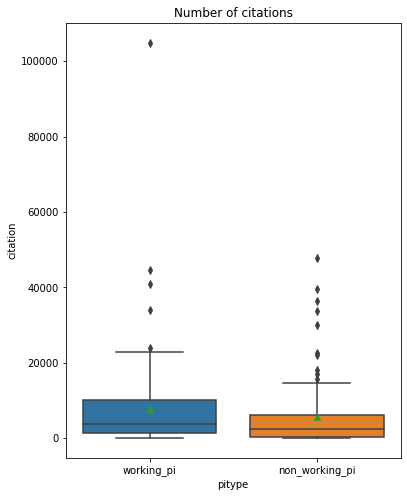

In [75]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="pitype", y="citation", data=box_plot_data, showmeans=True).set_title("Number of citations")

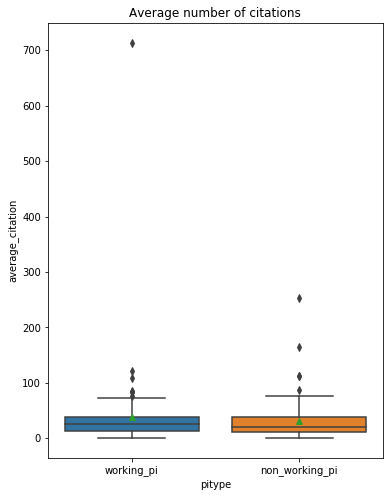

In [76]:
box_plot_data["average_citation"] = (box_plot_data["citation"]/box_plot_data["publication"]).fillna(0)
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="pitype", y="average_citation", data=box_plot_data, showmeans=True).set_title("Average number of citations")
